In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 18})
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train_data = pd.read_csv('train.csv',index_col=0,dtype={4: np.float32, 5: np.float32,6: np.float32,7: np.float32})
test_data  = pd.read_csv('test.csv', index_col=0,dtype={4: np.float32, 5: np.float32,6: np.float32,7: np.float32})
sample     = pd.read_csv('sample_submission.csv')

In [3]:
train_data.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
id,,,,,,,
1,1,20,50,0.000000,0.083334,0.0,5.837492
2,1,20,50,0.033652,18.383041,0.0,5.907794
3,1,20,50,0.067514,22.509277,0.0,7.876254
4,1,20,50,0.101542,22.808823,0.0,11.742872
5,1,20,50,0.135756,25.355850,0.0,12.234987


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6036000 entries, 1 to 6036000
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float32
 4   u_in       float32
 5   u_out      float32
 6   pressure   float32
dtypes: float32(4), int64(3)
memory usage: 276.3 MB


In [5]:
test_data.head()

,breath_id,R,C,time_step,u_in,u_out
id,,,,,,
1,0,5,20,0.000000,0.000000,0.0
2,0,5,20,0.031904,7.515046,0.0
3,0,5,20,0.063827,14.651675,0.0
4,0,5,20,0.095751,21.230610,0.0
5,0,5,20,0.127644,26.320955,0.0


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4024000 entries, 1 to 4024000
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   breath_id  int64  
 1   R          int64  
 2   C          int64  
 3   time_step  float32
 4   u_in       float32
 5   u_out      float32
dtypes: float32(3), int64(3)
memory usage: 168.9 MB


In [7]:
train_data.isnull().sum().to_frame()

,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0
pressure,0


In [8]:
test_data.isnull().sum().to_frame()

,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0


In [9]:
breath_one = train_data[train_data['breath_id'] == 3928].reset_index(drop=True)
breath_one

,breath_id,R,C,time_step,u_in,u_out,pressure
0,3928,50,10,0.000000,0.0,0.0,1.338154
1,3928,50,10,0.033322,0.0,0.0,1.408457
2,3928,50,10,0.066726,0.0,0.0,1.338154
3,3928,50,10,0.100185,0.0,0.0,1.338154
4,3928,50,10,0.133763,0.0,0.0,1.267852
...,...,...,...,...,...,...,...
75,3928,50,10,2.503395,0.0,1.0,0.143018
76,3928,50,10,2.536753,0.0,1.0,0.143018
77,3928,50,10,2.570070,0.0,1.0,-0.067889
78,3928,50,10,2.603431,0.0,1.0,0.072716


In [10]:
breath_one.nunique().to_frame()

,0
breath_id,1
R,1
C,1
time_step,80
u_in,1
u_out,2
pressure,23


Text(0.5, 1.0, 'pressure')

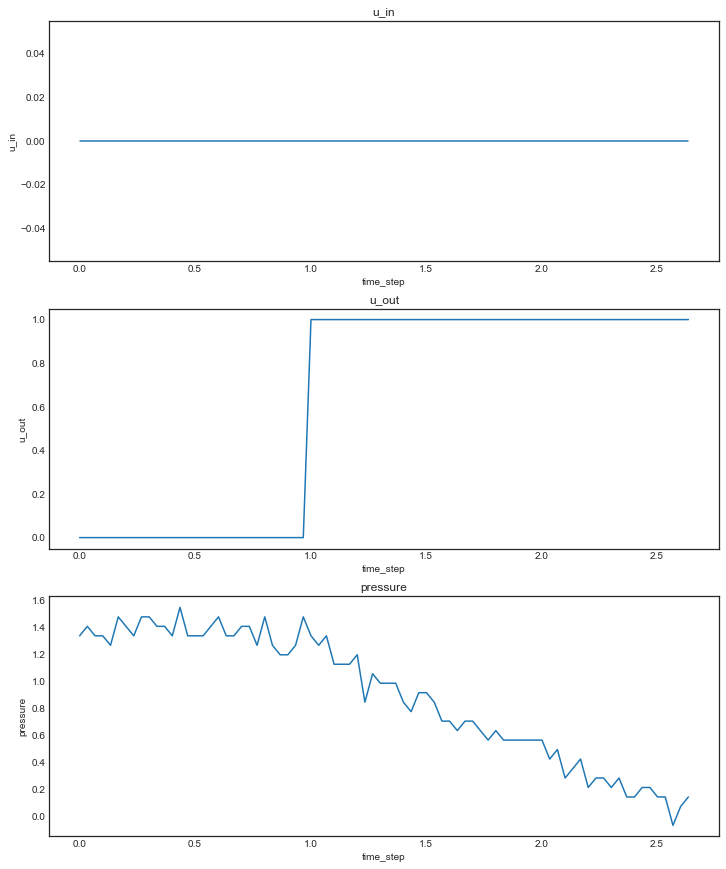

In [11]:
fig,axes = plt.subplots(3,1,figsize=(12,15))
sns.lineplot(x='time_step',y='u_in',data=breath_one,ax=axes[0])
axes[0].set_title("u_in")
sns.lineplot(x='time_step',y='u_out',data=breath_one,ax=axes[1])
axes[1].set_title("u_out")
sns.lineplot(x='time_step',y='pressure',data=breath_one,ax=axes[2])
axes[2].set_title("pressure")

In [12]:
breath_one.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure
count,80.0,80.0,80.0,80.000000,80.0,80.000000,80.000000
mean,3928.0,50.0,10.0,1.318887,0.0,0.625000,0.898766
std,0.0,0.0,0.0,0.775419,0.0,0.487177,0.472926
min,3928.0,50.0,10.0,0.000000,0.0,0.000000,-0.067889
25%,3928.0,50.0,10.0,0.659969,0.0,0.000000,0.564831
50%,3928.0,50.0,10.0,1.318991,0.0,1.000000,0.986644
75%,3928.0,50.0,10.0,1.977771,0.0,1.000000,1.338154
max,3928.0,50.0,10.0,2.636786,0.0,1.000000,1.549061


In [13]:
train_data.R.value_counts().to_frame()

,R
50,2410080
5,1988800
20,1637120


In [14]:
train_data.C.value_counts().to_frame()

,C
10,2244720
50,1971680
20,1819600


In [15]:
train_data.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.305158e+00,7.191073e+00,6.204493e-01,1.139944e+01
std,3.633526e+04,1.959549e+01,1.715231e+01,7.639102e-01,1.341283e+01,4.755873e-01,8.147921e+00
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386147e+00,1.000000e+00,7.032628e+00
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


<AxesSubplot:xlabel='pressure', ylabel='Count'>

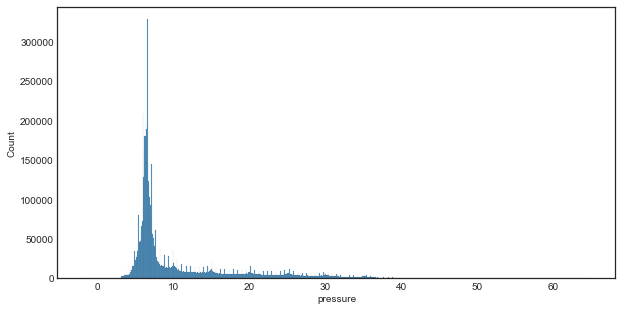

In [16]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
sns.histplot(data=train_data,x="pressure",ax=axes)

In [17]:
#add feature last_value_u_in
idxmax_time_step = train_data.groupby('breath_id')['time_step'].idxmax()
last_value_u_in = train_data.loc[idxmax_time_step, ['breath_id','u_in']]
last_value_u_in.columns = ['breath_id','last_value_u_in']

train_data = train_data.merge(last_value_u_in, on='breath_id')
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in
0,1,20,50,0.000000,0.083334,0.0,5.837492,4.987079
1,1,20,50,0.033652,18.383041,0.0,5.907794,4.987079
2,1,20,50,0.067514,22.509277,0.0,7.876254,4.987079
3,1,20,50,0.101542,22.808823,0.0,11.742872,4.987079
4,1,20,50,0.135756,25.355850,0.0,12.234987,4.987079
...,...,...,...,...,...,...,...,...
6035995,125749,50,10,2.504603,1.489714,1.0,3.869032,1.482739
6035996,125749,50,10,2.537961,1.488497,1.0,3.869032,1.482739
6035997,125749,50,10,2.571408,1.558978,1.0,3.798729,1.482739
6035998,125749,50,10,2.604744,1.272663,1.0,4.079938,1.482739


In [18]:
#add feature last_value_u_in
idxmax_time_step = test_data.groupby('breath_id')['time_step'].idxmax()
last_value_u_in = test_data.loc[idxmax_time_step, ['breath_id','u_in']]
last_value_u_in.columns = ['breath_id','last_value_u_in']

test_data = test_data.merge(last_value_u_in, on='breath_id')
test_data

,breath_id,R,C,time_step,u_in,u_out,last_value_u_in
0,0,5,20,0.000000,0.000000,0.0,4.973375
1,0,5,20,0.031904,7.515046,0.0,4.973375
2,0,5,20,0.063827,14.651675,0.0,4.973375
3,0,5,20,0.095751,21.230610,0.0,4.973375
4,0,5,20,0.127644,26.320955,0.0,4.973375
...,...,...,...,...,...,...,...
4023995,125748,20,10,2.530117,4.971245,1.0,4.985373
4023996,125748,20,10,2.563853,4.975709,1.0,4.985373
4023997,125748,20,10,2.597475,4.979467,1.0,4.985373
4023998,125748,20,10,2.631134,4.982648,1.0,4.985373


In [19]:
#add feature mean value u_in
mean_u_in = train_data.groupby('breath_id')['u_in'].mean().to_frame()
mean_u_in.columns = ['mean_value_u_in']
train_data = train_data.merge(mean_u_in,on='breath_id')

In [20]:
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in
0,1,20,50,0.000000,0.083334,0.0,5.837492,4.987079,10.146007
1,1,20,50,0.033652,18.383041,0.0,5.907794,4.987079,10.146007
2,1,20,50,0.067514,22.509277,0.0,7.876254,4.987079,10.146007
3,1,20,50,0.101542,22.808823,0.0,11.742872,4.987079,10.146007
4,1,20,50,0.135756,25.355850,0.0,12.234987,4.987079,10.146007
...,...,...,...,...,...,...,...,...,...
6035995,125749,50,10,2.504603,1.489714,1.0,3.869032,1.482739,4.911402
6035996,125749,50,10,2.537961,1.488497,1.0,3.869032,1.482739,4.911402
6035997,125749,50,10,2.571408,1.558978,1.0,3.798729,1.482739,4.911402
6035998,125749,50,10,2.604744,1.272663,1.0,4.079938,1.482739,4.911402


In [21]:
#add feature mean value u_in
mean_u_in = test_data.groupby('breath_id')['u_in'].mean().to_frame()
mean_u_in.columns = ['mean_value_u_in']
test_data = test_data.merge(mean_u_in,on='breath_id')
test_data

,breath_id,R,C,time_step,u_in,u_out,last_value_u_in,mean_value_u_in
0,0,5,20,0.000000,0.000000,0.0,4.973375,9.327337
1,0,5,20,0.031904,7.515046,0.0,4.973375,9.327337
2,0,5,20,0.063827,14.651675,0.0,4.973375,9.327337
3,0,5,20,0.095751,21.230610,0.0,4.973375,9.327337
4,0,5,20,0.127644,26.320955,0.0,4.973375,9.327337
...,...,...,...,...,...,...,...,...
4023995,125748,20,10,2.530117,4.971245,1.0,4.985373,2.682976
4023996,125748,20,10,2.563853,4.975709,1.0,4.985373,2.682976
4023997,125748,20,10,2.597475,4.979467,1.0,4.985373,2.682976
4023998,125748,20,10,2.631134,4.982648,1.0,4.985373,2.682976


In [22]:
train_data['diff_u_in'] = train_data.groupby('breath_id')['u_in'].diff()

In [24]:
train_data = train_data.fillna(0)
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in,diff_u_in
0,1,20,50,0.000000,0.083334,0.0,5.837492,4.987079,10.146007,0.000000
1,1,20,50,0.033652,18.383041,0.0,5.907794,4.987079,10.146007,18.299707
2,1,20,50,0.067514,22.509277,0.0,7.876254,4.987079,10.146007,4.126236
3,1,20,50,0.101542,22.808823,0.0,11.742872,4.987079,10.146007,0.299545
4,1,20,50,0.135756,25.355850,0.0,12.234987,4.987079,10.146007,2.547028
...,...,...,...,...,...,...,...,...,...,...
6035995,125749,50,10,2.504603,1.489714,1.0,3.869032,1.482739,4.911402,0.069002
6035996,125749,50,10,2.537961,1.488497,1.0,3.869032,1.482739,4.911402,-0.001217
6035997,125749,50,10,2.571408,1.558978,1.0,3.798729,1.482739,4.911402,0.070481
6035998,125749,50,10,2.604744,1.272663,1.0,4.079938,1.482739,4.911402,-0.286315


In [25]:
test_data['diff_u_in'] = test_data.groupby('breath_id')['u_in'].diff()
test_data = test_data.fillna(0)
test_data

,breath_id,R,C,time_step,u_in,u_out,last_value_u_in,mean_value_u_in,diff_u_in
0,0,5,20,0.000000,0.000000,0.0,4.973375,9.327337,0.000000
1,0,5,20,0.031904,7.515046,0.0,4.973375,9.327337,7.515046
2,0,5,20,0.063827,14.651675,0.0,4.973375,9.327337,7.136630
3,0,5,20,0.095751,21.230610,0.0,4.973375,9.327337,6.578935
4,0,5,20,0.127644,26.320955,0.0,4.973375,9.327337,5.090345
...,...,...,...,...,...,...,...,...,...
4023995,125748,20,10,2.530117,4.971245,1.0,4.985373,2.682976,0.005286
4023996,125748,20,10,2.563853,4.975709,1.0,4.985373,2.682976,0.004464
4023997,125748,20,10,2.597475,4.979467,1.0,4.985373,2.682976,0.003758
4023998,125748,20,10,2.631134,4.982648,1.0,4.985373,2.682976,0.003181


In [26]:
train_data['diff_diff_u_in'] = train_data.groupby('breath_id')['diff_u_in'].diff()
train_data = train_data.fillna(0)
train_data

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in,diff_u_in,diff_diff_u_in
0,1,20,50,0.000000,0.083334,0.0,5.837492,4.987079,10.146007,0.000000,0.000000
1,1,20,50,0.033652,18.383041,0.0,5.907794,4.987079,10.146007,18.299707,18.299707
2,1,20,50,0.067514,22.509277,0.0,7.876254,4.987079,10.146007,4.126236,-14.173471
3,1,20,50,0.101542,22.808823,0.0,11.742872,4.987079,10.146007,0.299545,-3.826691
4,1,20,50,0.135756,25.355850,0.0,12.234987,4.987079,10.146007,2.547028,2.247482
...,...,...,...,...,...,...,...,...,...,...,...
6035995,125749,50,10,2.504603,1.489714,1.0,3.869032,1.482739,4.911402,0.069002,0.001496
6035996,125749,50,10,2.537961,1.488497,1.0,3.869032,1.482739,4.911402,-0.001217,-0.070219
6035997,125749,50,10,2.571408,1.558978,1.0,3.798729,1.482739,4.911402,0.070481,0.071698
6035998,125749,50,10,2.604744,1.272663,1.0,4.079938,1.482739,4.911402,-0.286315,-0.356796


In [27]:
test_data['diff_diff_u_in'] = test_data.groupby('breath_id')['diff_u_in'].diff()
test_data = test_data.fillna(0)
test_data

,breath_id,R,C,time_step,u_in,u_out,last_value_u_in,mean_value_u_in,diff_u_in,diff_diff_u_in
0,0,5,20,0.000000,0.000000,0.0,4.973375,9.327337,0.000000,0.000000
1,0,5,20,0.031904,7.515046,0.0,4.973375,9.327337,7.515046,7.515046
2,0,5,20,0.063827,14.651675,0.0,4.973375,9.327337,7.136630,-0.378416
3,0,5,20,0.095751,21.230610,0.0,4.973375,9.327337,6.578935,-0.557695
4,0,5,20,0.127644,26.320955,0.0,4.973375,9.327337,5.090345,-1.488589
...,...,...,...,...,...,...,...,...,...,...
4023995,125748,20,10,2.530117,4.971245,1.0,4.985373,2.682976,0.005286,-0.001020
4023996,125748,20,10,2.563853,4.975709,1.0,4.985373,2.682976,0.004464,-0.000823
4023997,125748,20,10,2.597475,4.979467,1.0,4.985373,2.682976,0.003758,-0.000705
4023998,125748,20,10,2.631134,4.982648,1.0,4.985373,2.682976,0.003181,-0.000578


In [29]:
#add feature: comsum of u_in
train_data['u_in_cumsum'] = (train_data['u_in']).groupby(train_data['breath_id']).cumsum()
test_data['u_in_cumsum'] = (test_data['u_in']).groupby(test_data['breath_id']).cumsum()

In [30]:
#add feature sum value u_in
sum_u_in = train_data.groupby('breath_id')['u_in'].sum().to_frame()
sum_u_in.columns = ['sum_value_u_in']
train_data = train_data.merge(sum_u_in,on='breath_id')

In [31]:
#add feature sum value u_in
sum_u_in = test_data.groupby('breath_id')['u_in'].sum().to_frame()
sum_u_in.columns = ['sum_value_u_in']
test_data = test_data.merge(sum_u_in,on='breath_id')

In [32]:
#add feature : u_in_cumsum_rate
train_data["u_in_cumsum_rate"] = train_data["u_in_cumsum"] / train_data["sum_value_u_in"]
test_data["u_in_cumsum_rate"] = test_data["u_in_cumsum"] / test_data["sum_value_u_in"]

In [33]:
#sum breath_id has all zero u_in
train_data[train_data["sum_value_u_in"] == 0]

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in,diff_u_in,diff_diff_u_in,u_in_cumsum,sum_value_u_in,u_in_cumsum_rate
191200,3928,50,10,0.000000,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191201,3928,50,10,0.033322,0.0,0.0,1.408457,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191202,3928,50,10,0.066726,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191203,3928,50,10,0.100185,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191204,3928,50,10,0.133763,0.0,0.0,1.267852,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668795,118131,50,10,2.506284,0.0,1.0,-1.192723,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5668796,118131,50,10,2.539770,0.0,1.0,-1.263025,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5668797,118131,50,10,2.573175,0.0,1.0,-1.263025,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5668798,118131,50,10,2.606603,0.0,1.0,-1.192723,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [34]:
test_data[test_data["sum_value_u_in"] == 0]

,breath_id,R,C,time_step,u_in,u_out,last_value_u_in,mean_value_u_in,diff_u_in,diff_diff_u_in,u_in_cumsum,sum_value_u_in,u_in_cumsum_rate
188640,6001,50,10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
188641,6001,50,10,0.033615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
188642,6001,50,10,0.067265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
188643,6001,50,10,0.100764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
188644,6001,50,10,0.134327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904555,59587,50,10,2.503414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1904556,59587,50,10,2.536753,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1904557,59587,50,10,2.570463,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1904558,59587,50,10,2.603825,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [35]:
train_data[train_data["breath_id"] == 3928]

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in,diff_u_in,diff_diff_u_in,u_in_cumsum,sum_value_u_in,u_in_cumsum_rate
191200,3928,50,10,0.000000,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191201,3928,50,10,0.033322,0.0,0.0,1.408457,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191202,3928,50,10,0.066726,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191203,3928,50,10,0.100185,0.0,0.0,1.338154,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191204,3928,50,10,0.133763,0.0,0.0,1.267852,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191275,3928,50,10,2.503395,0.0,1.0,0.143018,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191276,3928,50,10,2.536753,0.0,1.0,0.143018,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191277,3928,50,10,2.570070,0.0,1.0,-0.067889,0.0,0.0,0.0,0.0,0.0,0.0,NaN
191278,3928,50,10,2.603431,0.0,1.0,0.072716,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [36]:
#so,null to zero
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [37]:
#add feature: lag of u_in
train_data['lag_u_in'] = train_data.groupby('breath_id')['u_in'].shift(1)
train_data = train_data.fillna(0)

test_data['lag_u_in'] = test_data.groupby('breath_id')['u_in'].shift(1)
test_data = test_data.fillna(0)

#add feature: lag2 of u_in
train_data['lag_2_u_in'] = train_data.groupby('breath_id')['u_in'].shift(2)
train_data = train_data.fillna(0)
test_data['lag_2_u_in'] = test_data.groupby('breath_id')['u_in'].shift(2)
test_data = test_data.fillna(0)

In [38]:
#add feature lag -1 and -2 u_in
train_data['lag_-1_u_in'] = train_data.groupby('breath_id')['u_in'].shift(-1)
train_data = train_data.fillna(0)
test_data['lag_-1_u_in'] = test_data.groupby('breath_id')['u_in'].shift(-1)
test_data = test_data.fillna(0)

train_data['lag_-2_u_in'] = train_data.groupby('breath_id')['u_in'].shift(-2)
train_data = train_data.fillna(0)
test_data['lag_-2_u_in'] = test_data.groupby('breath_id')['u_in'].shift(-2)
test_data = test_data.fillna(0)

In [39]:
#add feature lag -3 and 3 u_in
train_data['lag_-3_u_in'] = train_data.groupby('breath_id')['u_in'].shift(-3)
train_data = train_data.fillna(0)
test_data['lag_-3_u_in'] = test_data.groupby('breath_id')['u_in'].shift(-3)
test_data = test_data.fillna(0)

train_data['lag_3_u_in'] = train_data.groupby('breath_id')['u_in'].shift(3)
train_data = train_data.fillna(0)
test_data['lag_3_u_in'] = test_data.groupby('breath_id')['u_in'].shift(3)
test_data = test_data.fillna(0)

In [40]:
#add feature: max_u_in_breathid
train_data["max_u_in_breathid"] = train_data.groupby("breath_id")["u_in"].transform("max")
test_data["max_u_in_breathid"] = test_data.groupby("breath_id")["u_in"].transform("max")

#add feature: R*C
train_data["R*C"] = train_data['R'] * train_data['C']
test_data['R*C'] = test_data['R'] * test_data['C']

## add breath_id__u_in__min
train_data['breath_id__u_in__min'] = train_data.groupby(['breath_id'])['u_in'].transform('min')
test_data['breath_id__u_in__min'] = test_data.groupby(['breath_id'])['u_in'].transform('min')

## add breath_id__u_in__diffmax & breath_id__u_in__diffmean
train_data['breath_id__u_in__diffmax'] = train_data.groupby(['breath_id'])['u_in'].transform('max') - train_data['u_in']
train_data['breath_id__u_in__diffmean'] = train_data.groupby(['breath_id'])['u_in'].transform('mean') - train_data['u_in']

test_data['breath_id__u_in__diffmax'] = test_data.groupby(['breath_id'])['u_in'].transform('max') - test_data['u_in']
test_data['breath_id__u_in__diffmean'] = test_data.groupby(['breath_id'])['u_in'].transform('mean') - test_data['u_in']

train_data['u_in_partition_out_sum'] = train_data.groupby(['breath_id',"u_out"])['u_in'].transform("sum")
test_data['u_in_partition_out_sum'] = test_data.groupby(['breath_id',"u_out"])['u_in'].transform("sum")

##add feature area
train_data['area'] = train_data['time_step'] * train_data['u_in']
train_data['area'] = train_data.groupby('breath_id')['area'].cumsum()
test_data['area'] = test_data['time_step'] * test_data['u_in']
test_data['area'] = test_data.groupby('breath_id')['area'].cumsum()


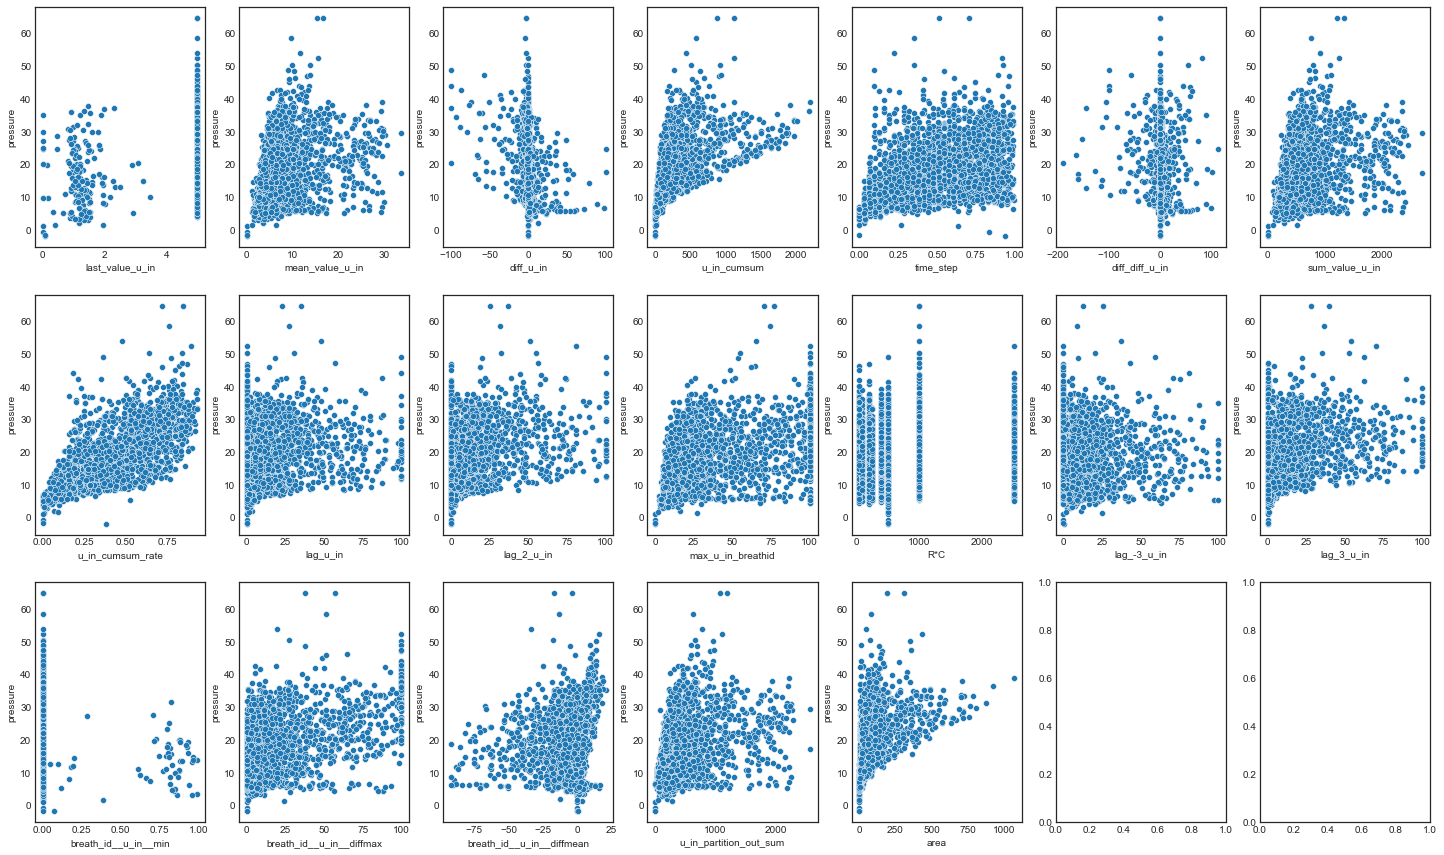

In [41]:
#scatter plot (u_out = 0)
GRAPH = True
if(GRAPH):
    sample_train = train_data.sample(frac=0.001)
    sample_train = sample_train[sample_train["u_out"] == 0]
    #check scatter with pressure and (last_value_u_in |mean_value_u_in| u_in_diff)
    fig,axes = plt.subplots(3,7,figsize=(25,15))
    sns.scatterplot(data=sample_train,x='last_value_u_in',y='pressure',ax=axes[0][0])
    sns.scatterplot(data=sample_train,x='mean_value_u_in',y='pressure',ax=axes[0][1])
    sns.scatterplot(data=sample_train,x='diff_u_in',y='pressure',ax=axes[0][2])
    sns.scatterplot(data=sample_train,x='u_in_cumsum',y='pressure',ax=axes[0][3])
    sns.scatterplot(data=sample_train,x='time_step',y='pressure',ax=axes[0][4])
    sns.scatterplot(data=sample_train,x='diff_diff_u_in',y='pressure',ax=axes[0][5])
    sns.scatterplot(data=sample_train,x='sum_value_u_in',y='pressure',ax=axes[0][6])
    sns.scatterplot(data=sample_train,x='u_in_cumsum_rate',y='pressure',ax=axes[1][0])
    sns.scatterplot(data=sample_train,x='lag_u_in',y='pressure',ax=axes[1][1])
    sns.scatterplot(data=sample_train,x='lag_2_u_in',y='pressure',ax=axes[1][2])
    sns.scatterplot(data=sample_train,x='max_u_in_breathid',y='pressure',ax=axes[1][3])
    sns.scatterplot(data=sample_train,x='R*C',y='pressure',ax=axes[1][4])
    sns.scatterplot(data=sample_train,x='lag_-3_u_in',y='pressure',ax=axes[1][5])
    sns.scatterplot(data=sample_train,x='lag_3_u_in',y='pressure',ax=axes[1][6])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__min',y='pressure',ax=axes[2][0])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__diffmax',y='pressure',ax=axes[2][1])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__diffmean',y='pressure',ax=axes[2][2])
    sns.scatterplot(data=sample_train,x='u_in_partition_out_sum',y='pressure',ax=axes[2][3])
    sns.scatterplot(data=sample_train,x='area',y='pressure',ax=axes[2][4])

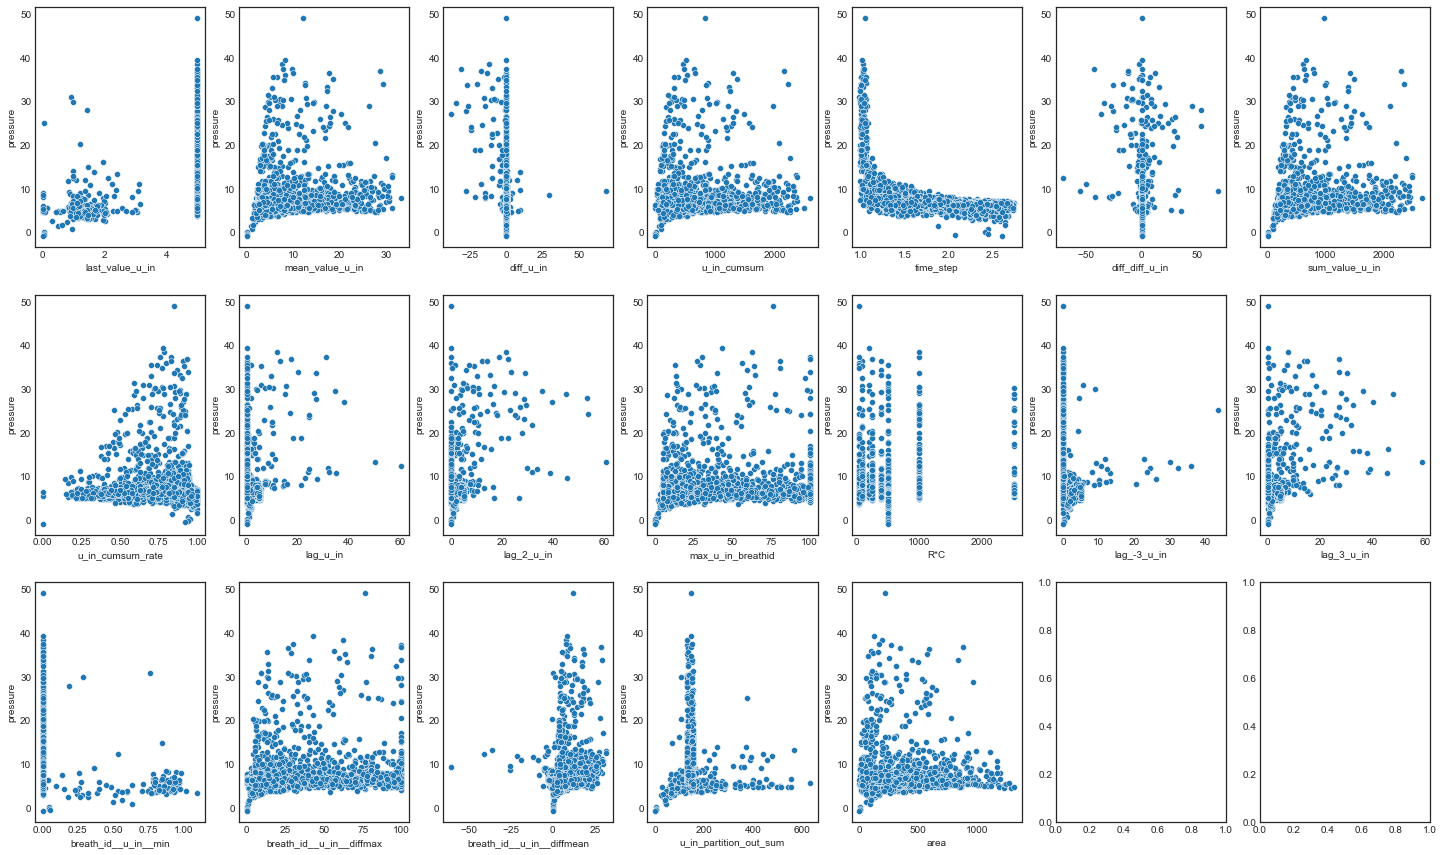

In [42]:
#scatter plot (u_out = 1)
GRAPH = True
if(GRAPH):
    sample_train = train_data.sample(frac=0.001)
    sample_train = sample_train[sample_train["u_out"] == 1]
    #check scatter with pressure and (last_value_u_in |mean_value_u_in| u_in_diff)
    fig,axes = plt.subplots(3,7,figsize=(25,15))
    sns.scatterplot(data=sample_train,x='last_value_u_in',y='pressure',ax=axes[0][0])
    sns.scatterplot(data=sample_train,x='mean_value_u_in',y='pressure',ax=axes[0][1])
    sns.scatterplot(data=sample_train,x='diff_u_in',y='pressure',ax=axes[0][2])
    sns.scatterplot(data=sample_train,x='u_in_cumsum',y='pressure',ax=axes[0][3])
    sns.scatterplot(data=sample_train,x='time_step',y='pressure',ax=axes[0][4])
    sns.scatterplot(data=sample_train,x='diff_diff_u_in',y='pressure',ax=axes[0][5])
    sns.scatterplot(data=sample_train,x='sum_value_u_in',y='pressure',ax=axes[0][6])
    sns.scatterplot(data=sample_train,x='u_in_cumsum_rate',y='pressure',ax=axes[1][0])
    sns.scatterplot(data=sample_train,x='lag_u_in',y='pressure',ax=axes[1][1])
    sns.scatterplot(data=sample_train,x='lag_2_u_in',y='pressure',ax=axes[1][2])
    sns.scatterplot(data=sample_train,x='max_u_in_breathid',y='pressure',ax=axes[1][3])
    sns.scatterplot(data=sample_train,x='R*C',y='pressure',ax=axes[1][4])
    sns.scatterplot(data=sample_train,x='lag_-3_u_in',y='pressure',ax=axes[1][5])
    sns.scatterplot(data=sample_train,x='lag_3_u_in',y='pressure',ax=axes[1][6])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__min',y='pressure',ax=axes[2][0])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__diffmax',y='pressure',ax=axes[2][1])
    sns.scatterplot(data=sample_train,x='breath_id__u_in__diffmean',y='pressure',ax=axes[2][2])
    sns.scatterplot(data=sample_train,x='u_in_partition_out_sum',y='pressure',ax=axes[2][3])
    sns.scatterplot(data=sample_train,x='area',y='pressure',ax=axes[2][4])

In [43]:
del fig
del axes
del sample_train

In [44]:
import gc
gc.collect()

46878

In [45]:
#add feature: R_C
train_data["train_test"] = "train"
test_data["train_test"] = "test"

train_test_all = pd.concat([train_data,test_data],axis=0)

del train_data
del test_data
gc.collect()

15

In [46]:
train_test_all

,breath_id,R,C,time_step,u_in,u_out,pressure,last_value_u_in,mean_value_u_in,diff_u_in,...,lag_-3_u_in,lag_3_u_in,max_u_in_breathid,R*C,breath_id__u_in__min,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_partition_out_sum,area,train_test
0,1,20,50,0.000000,0.083334,0.0,5.837492,4.987079,10.146007,0.000000,...,22.808823,0.000000,28.313036,1000,0.0,28.229702,10.062673,663.594727,0.000000,train
1,1,20,50,0.033652,18.383041,0.0,5.907794,4.987079,10.146007,18.299707,...,25.355850,0.000000,28.313036,1000,0.0,9.929995,-8.237035,663.594727,0.618632,train
2,1,20,50,0.067514,22.509277,0.0,7.876254,4.987079,10.146007,4.126236,...,27.259867,0.000000,28.313036,1000,0.0,5.803759,-12.363271,663.594727,2.138332,train
3,1,20,50,0.101542,22.808823,0.0,11.742872,4.987079,10.146007,0.299545,...,27.127485,0.083334,28.313036,1000,0.0,5.504213,-12.662816,663.594727,4.454391,train
4,1,20,50,0.135756,25.355850,0.0,12.234987,4.987079,10.146007,2.547028,...,26.807732,18.383041,28.313036,1000,0.0,2.957186,-15.209844,663.594727,7.896588,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,125748,20,10,2.530117,4.971245,1.0,NaN,4.985373,2.682976,0.005286,...,4.982648,4.952134,35.151390,200,0.0,30.180145,-2.288270,145.677017,270.095490,test
4023996,125748,20,10,2.563853,4.975709,1.0,NaN,4.985373,2.682976,0.004464,...,4.985373,4.959652,35.151390,200,0.0,30.175682,-2.292733,145.677017,282.852478,test
4023997,125748,20,10,2.597475,4.979467,1.0,NaN,4.985373,2.682976,0.003758,...,0.000000,4.965959,35.151390,200,0.0,30.171923,-2.296492,145.677017,295.786530,test
4023998,125748,20,10,2.631134,4.982648,1.0,NaN,4.985373,2.682976,0.003181,...,0.000000,4.971245,35.151390,200,0.0,30.168743,-2.299672,145.677017,308.896515,test


In [47]:
train_test_all['R_C'] = [f'{r}_{c}' for r, c in zip(train_test_all['R'], train_test_all['C'])]

In [48]:

train_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10060000 entries, 0 to 4023999
Data columns (total 29 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   breath_id                  int64  
 1   R                          int64  
 2   C                          int64  
 3   time_step                  float32
 4   u_in                       float32
 5   u_out                      float32
 6   pressure                   float32
 7   last_value_u_in            float32
 8   mean_value_u_in            float32
 9   diff_u_in                  float32
 10  diff_diff_u_in             float32
 11  u_in_cumsum                float32
 12  sum_value_u_in             float32
 13  u_in_cumsum_rate           float32
 14  lag_u_in                   float32
 15  lag_2_u_in                 float32
 16  lag_-1_u_in                float32
 17  lag_-2_u_in                float32
 18  lag_-3_u_in                float32
 19  lag_3_u_in                 float32
 20  m

In [49]:
train_test_all = pd.get_dummies(train_test_all,columns=["R_C"])
train_test_all.columns

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'last_value_u_in', 'mean_value_u_in', 'diff_u_in', 'diff_diff_u_in',
       'u_in_cumsum', 'sum_value_u_in', 'u_in_cumsum_rate', 'lag_u_in',
       'lag_2_u_in', 'lag_-1_u_in', 'lag_-2_u_in', 'lag_-3_u_in', 'lag_3_u_in',
       'max_u_in_breathid', 'R*C', 'breath_id__u_in__min',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean',
       'u_in_partition_out_sum', 'area', 'train_test', 'R_C_20_10',
       'R_C_20_20', 'R_C_20_50', 'R_C_50_10', 'R_C_50_20', 'R_C_50_50',
       'R_C_5_10', 'R_C_5_20', 'R_C_5_50'],
      dtype='object')

In [50]:
##add feaure time_diff
train_test_all['time_diff']=train_test_all.time_step.diff().fillna(0)

In [51]:
#Simple Regression Submit
train_data = train_test_all[train_test_all["train_test"] == "train"]
test_data = train_test_all[train_test_all["train_test"] == "test"]


In [52]:
del train_test_all
gc.collect()

60

In [53]:
LM = True
u_out_zero_only = False ## if train from only u_out=0 data

In [54]:
#train
if(u_out_zero_only):
    train_data = train_data[train_data["u_out"] == 0]
    train_data = train_data.reset_index(drop=True)
X_train = train_data.drop(["pressure","breath_id","train_test"],axis=1)
y_train = train_data['pressure']
X_test = test_data.drop(["pressure","breath_id","train_test"],axis=1)

if(LM):
    scaler = StandardScaler()
    scaler.fit(X_train)
    #print(scaler.mean_)

    X_train_std = scaler.transform(X_train)


    lm = LinearRegression().fit(X_train_std, y_train)
    print("coefficient of determination = ",lm.score(X_train_std, y_train))


    #test
    
    X_test_std = scaler.transform(X_test)
    sample['pressure'] = lm.predict(X_test_std)

    sample.to_csv("submission_lm.csv",index=False)

coefficient of determination =  0.7103221243271809


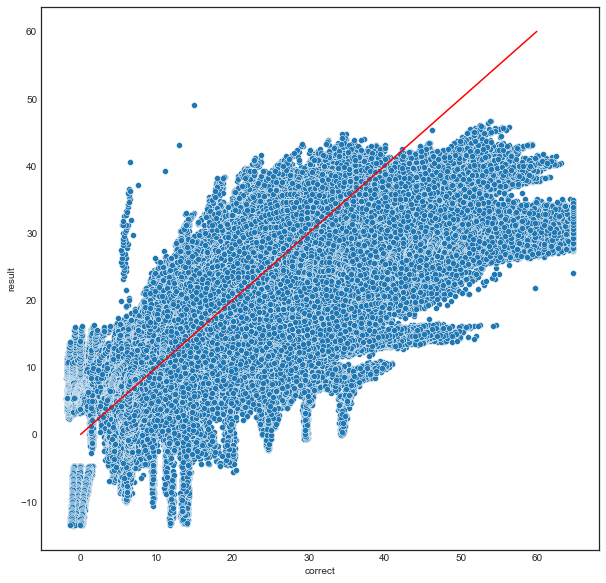

In [56]:
#plot scatter of corrct-predict of train_in_sample
if(LM):
    insample_result = pd.DataFrame()
    insample_result['correct'] = y_train
    insample_result['result'] = lm.predict(X_train_std)

    fig,axes = plt.subplots(1,1,figsize=(10,10))
    sns.scatterplot(data=insample_result,x='correct',y='result',ax=axes)

    x = np.linspace(0, 60, 10)
    y = x
    axes.plot(x, y, color = "r")

In [57]:
#calc insample MSE
if(LM):
    insample_MSE = mean_absolute_error(insample_result['correct'],insample_result['result'])
    print(insample_MSE)

3.1239983980438613


In [58]:
if(LM):
    del insample_result
    del fig
    del axes
    del X_train_std
    del X_test_std

del test_data

In [59]:
NEW_GBM = False
#LIghtGBM

In [61]:
!pip install lightgbm

In [62]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
import time
import lightgbm as lgb

from sklearn.model_selection import GroupKFold 
from sklearn.model_selection import  KFold
from sklearn import metrics

In [63]:
y_train

0           5.837492
1           5.907794
2           7.876254
3          11.742872
4          12.234987
             ...    
6035995     3.869032
6035996     3.869032
6035997     3.798729
6035998     4.079938
6035999     3.869032
Name: pressure, Length: 6036000, dtype: float32

In [64]:
#for scatterplot of lightgbm
gbm_val_result = pd.DataFrame()
gbm_val_result['correct'] = y_train


In [65]:
if(NEW_GBM):
    scores = []
    feature_importance = pd.DataFrame()
    columns = [col for col in train_data.columns if col not in ['id', 'breath_id', 'pressure',"train_test"]]

    models = []
    X = X_train
    y = y_train

    del X_train
    del y_train

    params = {'objective': 'regression',
              'learning_rate': 0.25,
              "boosting_type": "gbdt",
              'min_data_in_leaf':600,
              'max_bin': 196,
              #'device':'gpu',
              'feature_fraction':0.4,
              'lambda_l1':36, 'lambda_l2':80,
              'max_depth':16,
              'num_leaves':1000,
              "metric": 'mae',
              'n_jobs': -1
             }
    folds = GroupKFold(n_splits=5)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(train_data, y, groups=train_data['breath_id'])):
        print(f'Fold {fold_n} started at {time.ctime()}')
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        model = lgb.LGBMRegressor(**params, n_estimators=8000)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                verbose=100, early_stopping_rounds=10)
        score = metrics.mean_absolute_error(y_valid, model.predict(X_valid))

        models.append(model)
        scores.append(score)

        y_pred = model.predict(X_valid)

        gbm_val_result.loc[valid_index,["result"]] = y_pred #for scatterplot



        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [66]:
if(NEW_GBM):
    for model in models:
        sample['pressure'] += model.predict(X_test)
    sample['pressure'] /= 5

    sample.to_csv('submission.csv', index=False)
if(NEW_GBM):
    fig,axes = plt.subplots(1,1,figsize=(10,10))
    sns.scatterplot(data=gbm_val_result,x='correct',y='result',ax=axes)

    x = np.linspace(0, 60, 10)
    y = x
    axes.plot(x, y, color = "k")

In [67]:
#LightGBM (old)
#GroupID for Group-KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, KFold, train_test_split
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
groups = train_data["breath_id"]
#groups

In [68]:
OLD_GBM = True
if(OLD_GBM):
    # CV Averaging
    scores = []
    importance = []
    y_pred_test = np.zeros(len(X_test)) #array for predict value
    gkf = GroupKFold(n_splits=5)

    for i, (train_ix, test_ix) in tqdm(enumerate(gkf.split(X_train, y_train, groups))):

        X_train_, y_train_, groups_train_ = X_train.iloc[train_ix], y_train.iloc[train_ix], groups[train_ix]
        X_val, y_val, groups_val = X_train.iloc[test_ix], y_train.iloc[test_ix], groups[test_ix]

        print('Train Groups', np.unique(groups_train_))
        print('Val Groups', np.unique(groups_val))
        print(X_train_.shape, X_val.shape)

        model = lgb.LGBMRegressor(random_state=71, importance_type='gain')

        model.fit(X_train_, y_train_)
        y_pred = model.predict(X_val)

        gbm_val_result.loc[test_ix,["result"]] = y_pred #for scatterplot

        y_pred_test += model.predict(X_test) # add predict value

        score =  mean_absolute_error(y_val, y_pred)
        scores.append(score) 

        #importance
        importance_df = pd.DataFrame(model.feature_importances_, index = X_test.columns, columns=['importance'])
        importance.append(importance_df)

        print('CV Score of Fold_%d is %f' % (i, score))

<ipython-input-68-c1978b0aa3b0>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (train_ix, test_ix) in tqdm(enumerate(gkf.split(X_train, y_train, groups))):


0it [00:00, ?it/s]

Train Groups [     1      2      3 ... 125742 125743 125745]
Val Groups [     4     16     18 ... 125735 125740 125749]
(4828800, 35) (1207200, 35)
CV Score of Fold_0 is 0.733528
Train Groups [     1      2      3 ... 125743 125745 125749]
Val Groups [     5     12     17 ... 125730 125736 125742]
(4828800, 35) (1207200, 35)
CV Score of Fold_1 is 0.731540
Train Groups [     1      2      3 ... 125742 125745 125749]
Val Groups [     6      9     13 ... 125732 125737 125743]
(4828800, 35) (1207200, 35)
CV Score of Fold_2 is 0.732881
Train Groups [     1      3      4 ... 125742 125743 125749]
Val Groups [     2      7     14 ... 125733 125738 125745]
(4828800, 35) (1207200, 35)
CV Score of Fold_3 is 0.725088
Train Groups [     2      4      5 ... 125743 125745 125749]
Val Groups [     1      3     10 ... 125726 125734 125739]
(4828800, 35) (1207200, 35)
CV Score of Fold_4 is 0.734338


In [69]:
if(OLD_GBM):
    print(scores)
    print(np.mean(scores))

[0.7335280847008565, 0.7315400029083459, 0.7328809581541824, 0.7250880516581031, 0.7343383805628346]
0.7314750955968645


In [70]:
if(OLD_GBM):
    for df in importance:
        display(df.sort_values('importance',ascending=False))

,importance
time_step,6.454096e+08
u_in_cumsum,4.357894e+08
lag_2_u_in,1.158291e+08
u_in_partition_out_sum,7.791389e+07
lag_3_u_in,6.353334e+07
R,6.036575e+07
C,5.927625e+07
u_in_cumsum_rate,3.032833e+07
area,2.765048e+07
breath_id__u_in__diffmean,2.533182e+07


,importance
time_step,6.604016e+08
u_in_cumsum,4.420689e+08
lag_2_u_in,1.049306e+08
u_in_partition_out_sum,7.845055e+07
R,6.243976e+07
C,5.981863e+07
lag_3_u_in,5.544604e+07
u_in_cumsum_rate,3.030261e+07
area,2.848001e+07
breath_id__u_in__diffmean,2.470014e+07


,importance
time_step,6.848731e+08
u_in_cumsum,4.568067e+08
lag_2_u_in,1.114752e+08
C,6.179295e+07
R,5.995031e+07
lag_3_u_in,4.733315e+07
u_in_partition_out_sum,4.652538e+07
area,2.709205e+07
breath_id__u_in__diffmean,2.541523e+07
u_in_cumsum_rate,2.088751e+07


,importance
time_step,6.425200e+08
u_in_cumsum,4.338077e+08
lag_2_u_in,1.127561e+08
u_in_partition_out_sum,7.860707e+07
lag_3_u_in,6.395831e+07
C,6.197180e+07
R,5.879796e+07
u_in_cumsum_rate,3.126059e+07
area,2.656970e+07
breath_id__u_in__diffmean,2.474473e+07


,importance
time_step,6.889360e+08
u_in_cumsum,4.560097e+08
lag_2_u_in,1.077067e+08
C,5.952329e+07
R,5.623249e+07
lag_3_u_in,5.140978e+07
u_in_partition_out_sum,4.583914e+07
breath_id__u_in__diffmean,2.787703e+07
area,2.713445e+07
u_in_cumsum_rate,2.195769e+07


In [71]:
if(OLD_GBM):
    y_pred_test_submit = y_pred_test/5 #n_splits=5
    sample['pressure'] = y_pred_test_submit
    sample.to_csv("submission.csv",index=False)

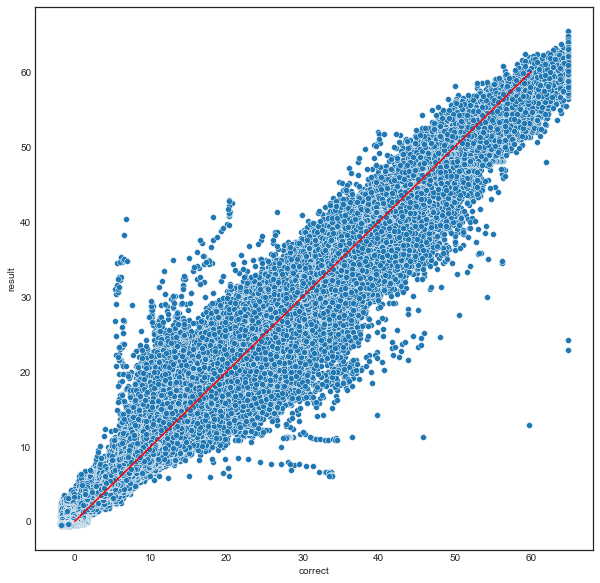

In [73]:
if(OLD_GBM):
    fig,axes = plt.subplots(1,1,figsize=(10,10))
    sns.scatterplot(data=gbm_val_result,x='correct',y='result',ax=axes)

    x = np.linspace(0, 60, 10)
    y = x
    axes.plot(x, y, color = "r")

In [ ]:
if(XGBRegressor):
    #train
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=700)
    xgb.fit(X_train, y_train)


    print("coefficient of determination = ", xgb.score(X_train, y_train))

    #test
    sample['pressure'] = xgb.predict(X_test)
    sample.to_csv("submission_xgb.csv",index=False)